# NSE Demonstrations

pynucastro is able to calculate the abundances at nuclear statistical equilibrium (NSE) of a given reaction network.

The constrained equations are setup following
{cite:t}`calder:2007` and {cite:t}`seitenzahl:2009`
and solved using `scipy.optimize.fsolve()`.

Here we show how to find the NSE state of a set of nuclei.

## Creating an `NSENetwork`

In [1]:
import pynucastro as pyna
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We start by creating a `Library` object that reads all the ReacLib rates and link different nuclei of choice. 

Then initialize `NSENetwork` by using the the rates created by the `Library` object.

In [2]:
library = pyna.ReacLibLibrary()

all_nuclei = ["p", "he4",
              "c12", "n13",
              "o16", "ne20", "na23",
              "mg24", "al27", "si28",
              "p31", "s32", "cl35",
              "ar36", "k39", "ca40",
              "sc43", "ti44", "v47",
              "cr48", "mn51",
              "fe52","co55","ni56"]

lib = library.linking_nuclei(all_nuclei)

nse = pyna.NSENetwork(libraries=lib)

We seek the NSE composition at a specified thermodynamic state, the `NSENetwork` solves the constraint equations
for the proton and neutron chemical potentials.  Then using this solution, it can compute the mass fractions.
The main interface for this is `get_comp_nse(rho, T, ye)` which returns the composition at NSE as a `Composition` object.

`get_comp_nse()` has options of incorporating Coulomb correction terms by setting `use_coulomb_corr=True`, and to return the proton and neutron chemical potentials by `return_sol=True`.

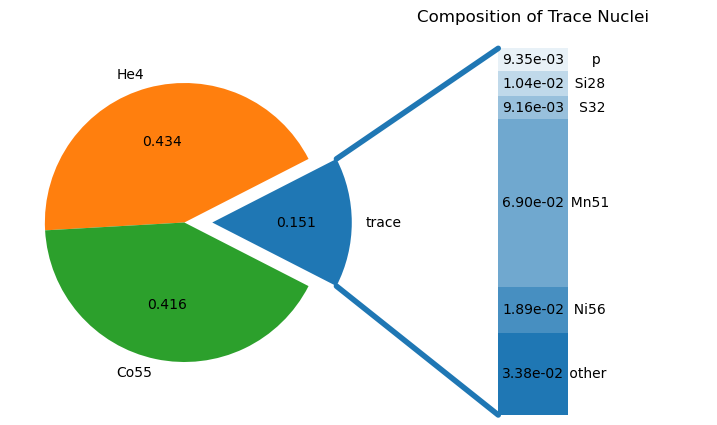

In [3]:
comp, sol = nse.get_comp_nse(1e7, 6e9, 0.50, use_coulomb_corr=True, return_sol=True)
fig = comp.plot()

```{tip}
There is pre-set initial guess for the proton and neutron chemical potentials, however one should adjust the initial guess, accordingly if no solutions are found or if the method is taking a long time to converge.
To pass in the initial guess, set `initial_guess=guess`, where `guess` is a user-supplied list of the form `[mu_p, mu_n]`, where `mu_p` and `mu_n` are the chemical potential for proton and neutron, respectively.
```

We can also explicitly print the composition

In [4]:
for c, v in comp.X.items():
    print(f"{str(c):6} : {v:15.8g}")

p      :    0.0093498981
He4    :      0.43364062
C12    :   7.7285996e-06
N13    :   2.5919027e-10
O16    :   1.5697524e-05
Ne20   :   3.0187405e-07
Na23   :   7.2969522e-08
Mg24   :   3.4701942e-05
Al27   :   3.3525822e-05
Si28   :     0.010439163
P31    :    0.0021350073
S32    :    0.0091606019
Cl35   :    0.0040009498
Ar36   :    0.0048794488
K39    :    0.0055527548
Ca40   :    0.0047700285
Sc43   :   0.00037267165
Ti44   :   0.00022927113
V47    :    0.0049046608
Cr48   :    0.0011465823
Mn51   :     0.068958575
Fe52   :    0.0057658969
Co55   :      0.41568674
Ni56   :     0.018915105


In [5]:
print(f"The chemical potential for proton and neutron are {sol[0]:10.7f} and {sol[1]:10.7f}")

The chemical potential for proton and neutron are -7.7387843 and -9.9990481


## NSE variation with temperature

For $\rho = 10^7~\mathrm{g~cm^{-3}}$ and electron fraction, $Y_e = 0.5$, we can explore how the NSE state changes with temperature.

Here we used a guess for chemical potential of proton and neutron of -6.0 and -11.5, respectively.

In [6]:
rho = 1e7
ye = 0.5
temps = np.linspace(2.5, 12.0, 100)
X_s = []

guess = [-6.0, -11.5]
for i, temp in enumerate(temps):
    nse_comp, sol = nse.get_comp_nse(rho, temp*1.0e9, ye, init_guess=guess, 
                                     use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s = [nse_comp.X[nuc] for nuc in nse_comp.X]
    X_s.append(nse_X_s)

Text(0.5, 1.0, '$Y_e = 0.5$, $\\rho =  1e+07$')

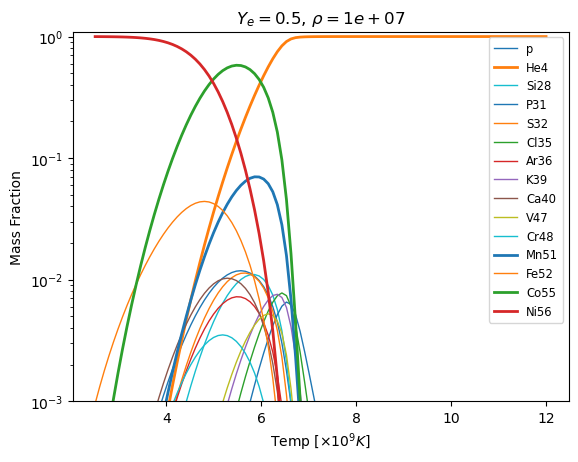

In [7]:
X_s = np.array(X_s)
nuc_names = nse.get_nuclei()

low_limit = 1e-3
fig, ax = plt.subplots()

for k in range(len(nuc_names)):
    lw = 1
    if max(X_s[:, k]) > 0.05:
        lw = 2    
    line, = ax.plot(temps, X_s[:,k], linewidth=lw)
    if (max(X_s[:,k]) > low_limit):
        line.set_label(str(nuc_names[k]))

ax.legend(loc="best", fontsize="small")
ax.set_xlabel(r'Temp $[\times 10^9 K]$')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([low_limit, 1.1])
ax.set_title(rf"$Y_e = {ye}$, $\rho = {rho:6.3g}$")

## NSE variation with $Y_e$

For $\rho = 10^7~\mathrm{g~cm^{-3}}$ and a relatively high temperature of $T = 6 \times 10^9~\mathrm{K}$, we can look at how the NSE state changes with varying $Y_e$.

Note: there will be a lowest $Y_e$ that is attainable by the network, depending on what species are represented. The NSE configuration with the lowest $Y_e$ is usually difficult to find and unlikely to happen in reality. For our current example network, achieving the lowest $Y_e$ means that mass fraction for N13 = 1. As long as protons are in the network, we can reach a $Y_e$ of $1$.

In [8]:
ye_low = min(nuc.Z/nuc.A for nuc in nse.unique_nuclei)

In [9]:
rho = 1e7
ye_s = np.linspace(ye_low, 0.65, 100)[1:]
temp = 6.0e9
X_s_1 = []

guess = [-6.0, -11.5]
for i, ye in enumerate(ye_s):
    nse_comp_1, sol = nse.get_comp_nse(rho, temp, ye, init_guess=guess, 
                                       use_coulomb_corr=True, return_sol=True)
    guess = sol
    nse_X_s_1 = [nse_comp_1.X[nuc] for nuc in nse_comp_1.X]
    X_s_1.append(nse_X_s_1)

Text(0.5, 1.0, '$\\rho =  1e+07$ and $T= 6e+09$')

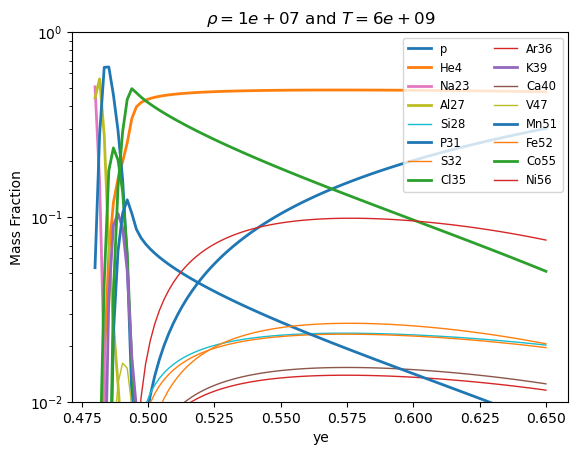

In [10]:
X_s_1 = np.array(X_s_1)
nuc_names = nse.get_nuclei()

fig, ax = plt.subplots()

for k in range(len(nuc_names)):
    lw = 1
    if max(X_s_1[:, k]) > 0.1:
        lw = 2
    line, = ax.plot(ye_s, X_s_1[:,k], linewidth=lw)
    if (max(X_s_1[:,k]) > 0.01):
        line.set_label(str(nuc_names[k]))

ax.legend(loc="best", fontsize="small", ncol=2)
ax.set_xlabel('ye')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([0.01, 1])
ax.set_title(rf"$\rho = {rho:6.3g}$ and $T={temp:6.3g}$")

## Comparison with Direct Integration

To further demonstrate the validity of the NSE equation, 
we will compare the equilibrium mass fractions computed via direct integration and the mass fractions obtained from NSE equations.

We will create the `PythonNetwork` needed for direct integration using the previously created `Library` object.
To do that we should first modify the previously created `Library` object so that we use reverse rates calculated via detailed balance.
In pynucastro, this is the `DerivedRate`.

First search through the existing ReacLib reverse rates and remove them. So that `Library` only contains forward rates

In [11]:
reverse_rates = lib.backward().get_rates()
for r in reverse_rates:
    lib.remove_rate(r)

Now create the corresponding `DerivedRate` using the forward rate and add them to `Library`. 

In [12]:
for r in lib.get_rates():
    d = pyna.DerivedRate(rate=r, compute_Q=True, use_pf=True)
    lib.add_rate(d)

We can also use `ModifiedRate` where we modify the reactants and/or the products of a reaction rate but still use the original rate. This is compatible with NSE as long as a corresponding `DerivedRate` is added.

In [13]:
other_rates = [("c12(c12,n)mg23", "mg24"),
               ("o16(o16,n)s31", "s32"),
               ("o16(c12,n)si27", "si28")]
for r, mp in other_rates:
    _r = library.get_rate_by_name(r)
    forward_rate = pyna.ModifiedRate(_r, new_products=[mp])
    derived_rate = pyna.DerivedRate(rate=forward_rate, compute_Q=True, use_pf=True)
    lib.add_rates([forward_rate, derived_rate])

Now create the `PythonNetwork` using the modified `Library` object.

In [14]:
net = pyna.PythonNetwork(libraries=lib)

We can also do some approximations, such as the $(\alpha,p)(p,\gamma)$ approximation. This is fully compatible with NSE.

In [15]:
net.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47", "mn51", "co55"])
net.remove_nuclei(["cl35", "k39", "sc43", "v47", "mn51", "co55"])

using approximate rate S32 + He4 ⟶ Ar36 + 𝛾
using approximate rate Ar36 ⟶ S32 + He4
using approximate rate Ar36 + He4 ⟶ Ca40 + 𝛾
using approximate rate Ca40 ⟶ Ar36 + He4
using approximate rate Ca40 + He4 ⟶ Ti44 + 𝛾
using approximate rate Ti44 ⟶ Ca40 + He4
using approximate rate Ti44 + He4 ⟶ Cr48 + 𝛾
using approximate rate Cr48 ⟶ Ti44 + He4
using approximate rate Cr48 + He4 ⟶ Fe52 + 𝛾
using approximate rate Fe52 ⟶ Cr48 + He4
using approximate rate Fe52 + He4 ⟶ Ni56 + 𝛾
using approximate rate Ni56 ⟶ Fe52 + He4
removing rate S32 + He4 ⟶ Ar36 + 𝛾
removing rate S32 + He4 ⟶ p + Cl35
removing rate Cl35 + p ⟶ Ar36 + 𝛾
removing rate Ar36 ⟶ He4 + S32
removing rate Ar36 ⟶ p + Cl35
removing rate Cl35 + p ⟶ He4 + S32
removing rate Ar36 + He4 ⟶ Ca40 + 𝛾
removing rate Ar36 + He4 ⟶ p + K39
removing rate K39 + p ⟶ Ca40 + 𝛾
removing rate Ca40 ⟶ He4 + Ar36
removing rate Ca40 ⟶ p + K39
removing rate K39 + p ⟶ He4 + Ar36
removing rate Ca40 + He4 ⟶ Ti44 + 𝛾
removing rate Ca40 + He4 ⟶ p + Sc43
removing rate 

Now write out python module that contains essential functions needed for integration, such as the `rhs` and `jacobian`.

In [16]:
net.write_network(outfile="network.py")

```{note}
In order for the integrated equilibrium result to be fully compatible with NSE equations, watch out for a number of things:
1. Make sure that all forward rates in the network has a corresponding `DerivedRate`. Otherwise there is no detailed balance.
2. All species are connected.
3. NSE only guarantees equilibrium of strong reactions. So if there are weak rates in the network, $Y_e$ will evolve in time.
```

Now import the network and the screening routine `potekhin_1998` and solve using `solve_ivp` from `scipy.integrate`

In [17]:
from scipy.integrate import solve_ivp
from pynucastro.screening import potekhin_1998
import network

Set up an initial condition and let it evolve until we reach equilibrium.

In [18]:
rho = 1e7
T = 6e9

X0 = np.ones(network.nnuc)
X0 /= np.sum(X0)
Y0 = X0/network.A

ye = network.ye(Y0)

tmax = 1.e-1
sol = solve_ivp(network.rhs, [0, tmax], Y0, method="BDF",
                 dense_output=True, args=(rho, T, potekhin_1998),
                 rtol=3.e-14, atol=3.e-14, jac=network.jacobian)

Plot to see how mass fraction evolve with time. Equilibrium is indicated by flat lines.

In [19]:
nucs = list(map(pyna.Nucleus, network.names))
nuc_labels = [f"${n.pretty}$" for n in nucs]

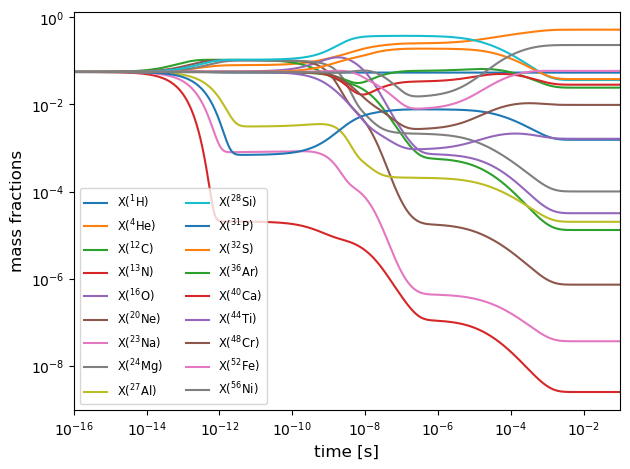

In [20]:
fig, ax = plt.subplots()
for i in range(network.nnuc):
    ax.loglog(sol.t, sol.y[i,:]*network.A[i], label=rf"X(${nucs[i].pretty}$)")

ax.set_xlim(1e-16, tmax)
ax.set_xlabel(f"time [s]", fontsize=12)
ax.set_ylabel(f"mass fractions", fontsize=12)
ax.legend(loc="best", fontsize="small", ncol=2)
fig.tight_layout()

Since `PythonNetwork` used $(\alpha,p)(p,\gamma)$ approximation, do the same for `NSENetwork`.
Then compute the mass fractions predicted from NSE equation.

In [21]:
nse.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47", "mn51", "co55"])
nse.remove_nuclei(["cl35", "k39", "sc43", "v47", "mn51", "co55"])
nse_comp = nse.get_comp_nse(rho, T, ye, init_guess=(-3.5, -14.0), use_coulomb_corr=True)

using approximate rate S32 + He4 ⟶ Ar36 + 𝛾
using approximate rate Ar36 ⟶ S32 + He4
using approximate rate Ar36 + He4 ⟶ Ca40 + 𝛾
using approximate rate Ca40 ⟶ Ar36 + He4
using approximate rate Ca40 + He4 ⟶ Ti44 + 𝛾
using approximate rate Ti44 ⟶ Ca40 + He4
using approximate rate Ti44 + He4 ⟶ Cr48 + 𝛾
using approximate rate Cr48 ⟶ Ti44 + He4
using approximate rate Cr48 + He4 ⟶ Fe52 + 𝛾
using approximate rate Fe52 ⟶ Cr48 + He4
using approximate rate Fe52 + He4 ⟶ Ni56 + 𝛾
using approximate rate Ni56 ⟶ Fe52 + He4
removing rate S32 + He4 ⟶ Ar36 + 𝛾
removing rate S32 + He4 ⟶ p + Cl35
removing rate Cl35 + p ⟶ Ar36 + 𝛾
removing rate Ar36 ⟶ He4 + S32
removing rate Ar36 ⟶ p + Cl35
removing rate Cl35 + p ⟶ He4 + S32
removing rate Ar36 + He4 ⟶ Ca40 + 𝛾
removing rate Ar36 + He4 ⟶ p + K39
removing rate K39 + p ⟶ Ca40 + 𝛾
removing rate Ca40 ⟶ He4 + Ar36
removing rate Ca40 ⟶ p + K39
removing rate K39 + p ⟶ He4 + Ar36
removing rate Ca40 + He4 ⟶ Ti44 + 𝛾
removing rate Ca40 + He4 ⟶ p + Sc43
removing rate 

Some plots to see the direct comparison between the two results.

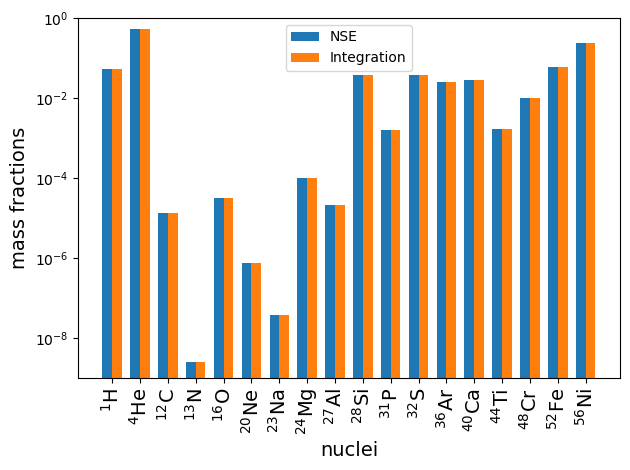

In [22]:
X_net = sol.y[:,-1]*network.A
X_nse = np.array(list(nse_comp.X.values()))

x = np.arange(len(network.names))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2.0, X_nse, width, label = 'NSE')
ax.bar(x + width/2.0, X_net, width, label = 'Integration')
ax.set_xlabel("nuclei", fontsize=14)
ax.set_xticks(x, labels=nuc_labels, rotation=90, fontsize=14)
ax.set_ylabel("mass fractions", fontsize=14)
ax.legend(fontsize=14)
ax.set_yscale("log")
ax.set_ylim(ymax = 1)
ax.legend()
fig.tight_layout()

Now a plot of absolute and relative difference shows that the mass fraction obtained from direct integration matches with NSE equations to machine precision. The differences between the two are largely set by the tolerances of both the NSE solver and the ODE integrator.

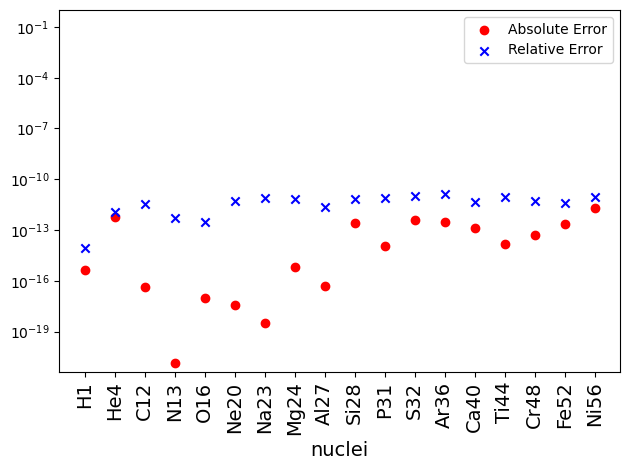

In [23]:
diff = np.abs(X_net - X_nse) 
diff_rel = diff / X_net

fig, ax = plt.subplots()
ax.scatter(x, diff, label='Absolute Error', marker='o', color='r')
ax.scatter(x, diff_rel, label='Relative Error', marker ='x', color='b')
ax.set_xticks(x, labels=nucs, rotation=90, fontsize=14)
ax.set_xlabel("nuclei", fontsize=14)
ax.set_yscale("log")
ax.legend(fontsize=14)
ax.set_ylim(ymax = 1)
ax.legend()
fig.tight_layout()